#### Conda env : kyuwon_video_swin_transformer(Python 3.10.11)
---
#### [주의사항]
##### Image Size가 (224,224,3)인 경우 Model Parameter를 아래와 같이 고정할 것
##### model = SwinTRansformer3D(patch_size=(4,4,4), embed_dim=96)


In [1]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import random
import cv2
import pickle
import torch.nn as nn
import torch
import datetime
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader
import logging
import torch
import torch.nn as nn
from einops import rearrange, reduce
from tqdm import tqdm
import gc
import copy

# 사용하고자 하는 model
# Fat_Transformer
# from Fat_Transformer.Only_Fat_transformer.model import SwinTransformer3D

# R(2+1)D + Fat_Transformer
from Fat_Transformer.R2plus1d_Fat_Transformer.model import SwinTransformer3D

# 2D_Patch_Partition, R(2+1)D + Fat_Transformer
# from Video_Swin_Transformer.Patch_Partition_R2plus1d_Video_Swin_Transformer.model import SwinTransformer3D


save_model_file_path = './save_model_3/{}_{}.{}'

/home/ssrlab/anaconda3/envs/kyuwon_video_swin_transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batchsz = 8
num_workers = 4
epochs = 120
start_epoch = 0
lr = 3e-5

In [3]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:', device)

True
학습을 진행하는 기기: cuda:0


In [4]:
with open('/home/ssrlab/kw/개성형성/Data_Pre_Processing/Video/training_set_full_shot_224x224x3_16frame.dat', "rb") as training_file:
    train_input_temp = pickle.load(training_file)
with open('/home/ssrlab/kw/개성형성/Data_Pre_Processing/Video/validation_set_full_shot_224x224x3_16frame.dat', "rb") as training_file:
    valid_input_temp = pickle.load(training_file)
    
# 15 Frame / Full-Frame / 224x224x3:/home/ssrlab/kw/개성형성/video_swin_transformer/Data_Processing/15Frame/Full-Shot/training_set.dat , /home/ssrlab/kw/개성형성/video_swin_transformer/Data_Processing/15Frame/Full-Shot/validation_set.dat
# 15 Frame / Face / 224x224x3 : 
# 15 Frame / Face / 128x128x3 : 

In [7]:
class ChalearnDataset(Dataset):
    def __init__(self,imagedata,tagdata,transform=None):
        self.imagedata=imagedata
        self.tagdata=tagdata
        self.transform = transform
        
    def __len__(self):
        return len(self.imagedata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_data=self.imagedata[idx]
        image_data=torch.FloatTensor(image_data)
        big_five_sorces=self.tagdata[idx]
        big_five_sorces = torch.FloatTensor(big_five_sorces)
        return image_data,big_five_sorces

In [8]:
train_dataset = ChalearnDataset(imagedata=train_input_temp[0],tagdata=train_input_temp[1])
val_dataset = ChalearnDataset(imagedata=valid_input_temp[0],tagdata=valid_input_temp[1])
# test_dataset = ChalearnDataset(imagedata=test_set_data,tagdata=test_y,transform=transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batchsz, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batchsz, shuffle=True, num_workers=num_workers)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=batchsz, shuffle=True, num_workers=num_workerssz)
max_value=0

# 모델 로드

In [9]:
model=SwinTransformer3D(patch_size=(4,4,4), embed_dim=96)

model.to(device)

criterion = torch.nn.L1Loss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

R2plus1d_pretrained_model


/home/ssrlab/anaconda3/envs/kyuwon_video_swin_transformer/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# from torchinfo import summary

# summary(model, input_size = (4,3,15,224,224), col_names = ['input_size','output_size','num_params'], verbose=1)

In [11]:
# checkpoint=torch.load("./save_model_2/model_33.pth", map_location=device)
# model.load_state_dict(checkpoint["model"])
# optimizer.load_state_dict(checkpoint["optimizer"])
# start_epoch = checkpoint['epoch']

# 학습

In [12]:
torch.set_printoptions(profile="full")

with torch.cuda.device(0):
    
    trainingEpoch_loss = []
    validationEpoch_loss = []
    
    for i in range(start_epoch,120):
        train_avg_loss = 0
        val_avg_loss = 0
        
        model.train()
        for image_data, big_five_data in tqdm(train_dataloader):
            
            image_data = rearrange(image_data, 'b d h w c -> b c d h w')
            image_data = image_data.to(device)
            
            big_five_data = reduce(big_five_data,'b c d -> b c', 'max')
            big_five_data = big_five_data.to(device)
            
            optimizer.zero_grad()
            hypothesis = model(image_data)
            
            loss = criterion(hypothesis, big_five_data)
            
            loss.backward()
            optimizer.step()
            
            train_avg_loss += loss
        train_avg_loss=train_avg_loss/len(train_dataloader)
        trainingEpoch_loss.append(train_avg_loss)
        print('Epoch = {}, 1 - train_loss = {}'.format(i+1,(1 - train_avg_loss)))
        
        
        with torch.no_grad():
            model.eval()
            for image_data, big_five_data in tqdm(val_dataloader):
                
                image_data = rearrange(image_data, 'b d h w c -> b c d h w')
                image_data = image_data.to(device)
                
                big_five_data = reduce(big_five_data,'b c d -> b c', 'max')
                big_five_data = big_five_data.to(device)
                
                hypothesis = model(image_data)
                
                val_loss = criterion(hypothesis, big_five_data)
                val_avg_loss += val_loss
                
            val_avg_loss=val_avg_loss/len(val_dataloader)
            validationEpoch_loss.append(val_avg_loss)
        print('Epoch = {}, 1 - val_loss = {}'.format(i+1,(1 - val_avg_loss)))
        print('\n')

        start_epoch+=1

        torch.save({
            'epoch': i+1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, save_model_file_path.format('model',start_epoch,'pth'))
        
        torch.cuda.empty_cache()
        gc.collect()

100%|██████████| 750/750 [29:02<00:00,  2.32s/it]


Epoch = 1, 1 - train_loss = 0.8372814655303955


100%|██████████| 250/250 [08:03<00:00,  1.93s/it]


Epoch = 1, 1 - val_loss = 0.8791294693946838




100%|██████████| 750/750 [25:57<00:00,  2.08s/it]


Epoch = 2, 1 - train_loss = 0.8711041808128357


100%|██████████| 250/250 [06:08<00:00,  1.47s/it]


Epoch = 2, 1 - val_loss = 0.8917357325553894




100%|██████████| 750/750 [27:14<00:00,  2.18s/it]


Epoch = 3, 1 - train_loss = 0.8835579752922058


100%|██████████| 250/250 [08:29<00:00,  2.04s/it]


Epoch = 3, 1 - val_loss = 0.886019229888916




100%|██████████| 750/750 [28:47<00:00,  2.30s/it]


Epoch = 4, 1 - train_loss = 0.8919610977172852


100%|██████████| 250/250 [08:24<00:00,  2.02s/it]


Epoch = 4, 1 - val_loss = 0.8984457850456238




100%|██████████| 750/750 [23:56<00:00,  1.92s/it]


Epoch = 5, 1 - train_loss = 0.9022223949432373


100%|██████████| 250/250 [06:32<00:00,  1.57s/it]


Epoch = 5, 1 - val_loss = 0.8837141990661621




100%|██████████| 750/750 [25:04<00:00,  2.01s/it]


Epoch = 6, 1 - train_loss = 0.9125316143035889


100%|██████████| 250/250 [07:09<00:00,  1.72s/it]


Epoch = 6, 1 - val_loss = 0.9031404852867126




100%|██████████| 750/750 [29:09<00:00,  2.33s/it]


Epoch = 7, 1 - train_loss = 0.9194390773773193


100%|██████████| 250/250 [08:32<00:00,  2.05s/it]


Epoch = 7, 1 - val_loss = 0.885979175567627




100%|██████████| 750/750 [29:00<00:00,  2.32s/it]


Epoch = 8, 1 - train_loss = 0.9253525137901306


100%|██████████| 250/250 [08:45<00:00,  2.10s/it]


Epoch = 8, 1 - val_loss = 0.9092676043510437




100%|██████████| 750/750 [30:06<00:00,  2.41s/it]


Epoch = 9, 1 - train_loss = 0.9298417568206787


100%|██████████| 250/250 [08:44<00:00,  2.10s/it]


Epoch = 9, 1 - val_loss = 0.9075967073440552




100%|██████████| 750/750 [27:58<00:00,  2.24s/it]


Epoch = 10, 1 - train_loss = 0.9325194358825684


100%|██████████| 250/250 [08:31<00:00,  2.05s/it]


Epoch = 10, 1 - val_loss = 0.902938961982727




100%|██████████| 750/750 [28:47<00:00,  2.30s/it]


Epoch = 11, 1 - train_loss = 0.9366934895515442


100%|██████████| 250/250 [07:37<00:00,  1.83s/it]


Epoch = 11, 1 - val_loss = 0.9055948257446289




100%|██████████| 750/750 [30:34<00:00,  2.45s/it]


Epoch = 12, 1 - train_loss = 0.9392962455749512


100%|██████████| 250/250 [08:45<00:00,  2.10s/it]


Epoch = 12, 1 - val_loss = 0.9064809679985046




100%|██████████| 750/750 [27:28<00:00,  2.20s/it]


Epoch = 13, 1 - train_loss = 0.9416840672492981


100%|██████████| 250/250 [08:44<00:00,  2.10s/it]


Epoch = 13, 1 - val_loss = 0.9077707529067993




100%|██████████| 750/750 [30:18<00:00,  2.43s/it]


Epoch = 14, 1 - train_loss = 0.943638801574707


100%|██████████| 250/250 [08:40<00:00,  2.08s/it]


Epoch = 14, 1 - val_loss = 0.908174455165863




100%|██████████| 750/750 [29:16<00:00,  2.34s/it]


Epoch = 15, 1 - train_loss = 0.9455205202102661


100%|██████████| 250/250 [08:50<00:00,  2.12s/it]


Epoch = 15, 1 - val_loss = 0.9101779460906982




100%|██████████| 750/750 [28:11<00:00,  2.25s/it]


Epoch = 16, 1 - train_loss = 0.9482467770576477


100%|██████████| 250/250 [07:07<00:00,  1.71s/it]


Epoch = 16, 1 - val_loss = 0.9073848724365234




100%|██████████| 750/750 [29:11<00:00,  2.34s/it]


Epoch = 17, 1 - train_loss = 0.9500008225440979


100%|██████████| 250/250 [06:15<00:00,  1.50s/it]


Epoch = 17, 1 - val_loss = 0.9107574224472046




100%|██████████| 750/750 [29:18<00:00,  2.34s/it]


Epoch = 18, 1 - train_loss = 0.9524074792861938


100%|██████████| 250/250 [08:42<00:00,  2.09s/it]


Epoch = 18, 1 - val_loss = 0.9089230298995972




100%|██████████| 750/750 [30:18<00:00,  2.42s/it]


Epoch = 19, 1 - train_loss = 0.9542867541313171


100%|██████████| 250/250 [08:00<00:00,  1.92s/it]


Epoch = 19, 1 - val_loss = 0.9096890687942505




100%|██████████| 750/750 [29:52<00:00,  2.39s/it]


Epoch = 20, 1 - train_loss = 0.9567364454269409


100%|██████████| 250/250 [08:26<00:00,  2.03s/it]


Epoch = 20, 1 - val_loss = 0.9106730222702026




100%|██████████| 750/750 [30:18<00:00,  2.42s/it]


Epoch = 21, 1 - train_loss = 0.9581597447395325


100%|██████████| 250/250 [08:17<00:00,  1.99s/it]


Epoch = 21, 1 - val_loss = 0.909231960773468




100%|██████████| 750/750 [27:00<00:00,  2.16s/it]


Epoch = 22, 1 - train_loss = 0.9600464105606079


100%|██████████| 250/250 [08:07<00:00,  1.95s/it]


Epoch = 22, 1 - val_loss = 0.9077973365783691




100%|██████████| 750/750 [29:31<00:00,  2.36s/it]


Epoch = 23, 1 - train_loss = 0.9609106779098511


100%|██████████| 250/250 [06:47<00:00,  1.63s/it]


Epoch = 23, 1 - val_loss = 0.9090660214424133




100%|██████████| 750/750 [26:09<00:00,  2.09s/it]


Epoch = 24, 1 - train_loss = 0.9635530710220337


100%|██████████| 250/250 [08:46<00:00,  2.10s/it]


Epoch = 24, 1 - val_loss = 0.9105766415596008




100%|██████████| 750/750 [30:26<00:00,  2.43s/it]


Epoch = 25, 1 - train_loss = 0.9650359153747559


100%|██████████| 250/250 [06:17<00:00,  1.51s/it]


Epoch = 25, 1 - val_loss = 0.9112504720687866




100%|██████████| 750/750 [28:28<00:00,  2.28s/it]


Epoch = 26, 1 - train_loss = 0.9669296145439148


100%|██████████| 250/250 [08:07<00:00,  1.95s/it]


Epoch = 26, 1 - val_loss = 0.910783052444458




100%|██████████| 750/750 [30:13<00:00,  2.42s/it]


Epoch = 27, 1 - train_loss = 0.9679900407791138


100%|██████████| 250/250 [07:26<00:00,  1.79s/it]


Epoch = 27, 1 - val_loss = 0.9104114770889282




100%|██████████| 750/750 [28:00<00:00,  2.24s/it]


Epoch = 28, 1 - train_loss = 0.9689642786979675


100%|██████████| 250/250 [08:10<00:00,  1.96s/it]


Epoch = 28, 1 - val_loss = 0.9105656743049622




100%|██████████| 750/750 [30:59<00:00,  2.48s/it]


Epoch = 29, 1 - train_loss = 0.9701135754585266


100%|██████████| 250/250 [08:07<00:00,  1.95s/it]


Epoch = 29, 1 - val_loss = 0.9113107919692993




100%|██████████| 750/750 [30:08<00:00,  2.41s/it]


Epoch = 30, 1 - train_loss = 0.9709911346435547


100%|██████████| 250/250 [09:00<00:00,  2.16s/it]


Epoch = 30, 1 - val_loss = 0.9086040258407593




100%|██████████| 750/750 [29:58<00:00,  2.40s/it]


Epoch = 31, 1 - train_loss = 0.9711337685585022


100%|██████████| 250/250 [08:05<00:00,  1.94s/it]


Epoch = 31, 1 - val_loss = 0.9114193320274353




100%|██████████| 750/750 [29:01<00:00,  2.32s/it]


Epoch = 32, 1 - train_loss = 0.9727905988693237


100%|██████████| 250/250 [08:45<00:00,  2.10s/it]


Epoch = 32, 1 - val_loss = 0.9107121825218201




100%|██████████| 750/750 [28:18<00:00,  2.26s/it]


Epoch = 33, 1 - train_loss = 0.9731673002243042


100%|██████████| 250/250 [07:30<00:00,  1.80s/it]


Epoch = 33, 1 - val_loss = 0.9111138582229614




100%|██████████| 750/750 [28:14<00:00,  2.26s/it]


Epoch = 34, 1 - train_loss = 0.9733158946037292


100%|██████████| 250/250 [08:16<00:00,  1.99s/it]


Epoch = 34, 1 - val_loss = 0.9099964499473572




100%|██████████| 750/750 [30:36<00:00,  2.45s/it]


Epoch = 35, 1 - train_loss = 0.974288284778595


100%|██████████| 250/250 [08:11<00:00,  1.97s/it]


Epoch = 35, 1 - val_loss = 0.9116605520248413




100%|██████████| 750/750 [28:22<00:00,  2.27s/it]


Epoch = 36, 1 - train_loss = 0.9748089909553528


100%|██████████| 250/250 [08:18<00:00,  1.99s/it]


Epoch = 36, 1 - val_loss = 0.9111607670783997




100%|██████████| 750/750 [30:23<00:00,  2.43s/it]


Epoch = 37, 1 - train_loss = 0.97532719373703


100%|██████████| 250/250 [08:28<00:00,  2.04s/it]


Epoch = 37, 1 - val_loss = 0.9105967283248901




100%|██████████| 750/750 [29:12<00:00,  2.34s/it]


Epoch = 38, 1 - train_loss = 0.9751874804496765


100%|██████████| 250/250 [06:22<00:00,  1.53s/it]


Epoch = 38, 1 - val_loss = 0.9112213253974915




100%|██████████| 750/750 [30:12<00:00,  2.42s/it]


Epoch = 39, 1 - train_loss = 0.9757525324821472


100%|██████████| 250/250 [08:06<00:00,  1.95s/it]


Epoch = 39, 1 - val_loss = 0.9109845757484436




100%|██████████| 750/750 [30:31<00:00,  2.44s/it]


Epoch = 40, 1 - train_loss = 0.9760666489601135


100%|██████████| 250/250 [07:53<00:00,  1.90s/it]


Epoch = 40, 1 - val_loss = 0.9102895259857178




100%|██████████| 750/750 [30:40<00:00,  2.45s/it]


Epoch = 41, 1 - train_loss = 0.9763156771659851


100%|██████████| 250/250 [08:03<00:00,  1.93s/it]


Epoch = 41, 1 - val_loss = 0.9096196889877319




100%|██████████| 750/750 [29:24<00:00,  2.35s/it]


Epoch = 42, 1 - train_loss = 0.9767389297485352


100%|██████████| 250/250 [08:52<00:00,  2.13s/it]


Epoch = 42, 1 - val_loss = 0.9107002019882202




100%|██████████| 750/750 [30:40<00:00,  2.45s/it]


Epoch = 43, 1 - train_loss = 0.977144181728363


100%|██████████| 250/250 [07:26<00:00,  1.78s/it]


Epoch = 43, 1 - val_loss = 0.9112762212753296




100%|██████████| 750/750 [29:11<00:00,  2.34s/it]


Epoch = 44, 1 - train_loss = 0.9771525859832764


100%|██████████| 250/250 [07:40<00:00,  1.84s/it]


Epoch = 44, 1 - val_loss = 0.9108802080154419




100%|██████████| 750/750 [29:14<00:00,  2.34s/it]


Epoch = 45, 1 - train_loss = 0.9774548411369324


100%|██████████| 250/250 [09:03<00:00,  2.17s/it]


Epoch = 45, 1 - val_loss = 0.911357045173645




100%|██████████| 750/750 [25:57<00:00,  2.08s/it]


Epoch = 46, 1 - train_loss = 0.9777224659919739


100%|██████████| 250/250 [06:21<00:00,  1.53s/it]


Epoch = 46, 1 - val_loss = 0.9107978343963623




100%|██████████| 750/750 [26:57<00:00,  2.16s/it]


Epoch = 47, 1 - train_loss = 0.9779179692268372


100%|██████████| 250/250 [08:46<00:00,  2.11s/it]


Epoch = 47, 1 - val_loss = 0.9104284644126892




100%|██████████| 750/750 [29:16<00:00,  2.34s/it]


Epoch = 48, 1 - train_loss = 0.9785971641540527


100%|██████████| 250/250 [08:27<00:00,  2.03s/it]


Epoch = 48, 1 - val_loss = 0.9113140106201172




100%|██████████| 750/750 [31:22<00:00,  2.51s/it]


Epoch = 49, 1 - train_loss = 0.9789331555366516


100%|██████████| 250/250 [07:12<00:00,  1.73s/it]


Epoch = 49, 1 - val_loss = 0.9099459052085876




100%|██████████| 750/750 [31:27<00:00,  2.52s/it]


Epoch = 50, 1 - train_loss = 0.9787297248840332


100%|██████████| 250/250 [08:48<00:00,  2.12s/it]


Epoch = 50, 1 - val_loss = 0.9111753702163696




100%|██████████| 750/750 [25:50<00:00,  2.07s/it]


Epoch = 51, 1 - train_loss = 0.9788474440574646


100%|██████████| 250/250 [07:58<00:00,  1.91s/it]


Epoch = 51, 1 - val_loss = 0.9115463495254517




100%|██████████| 750/750 [30:01<00:00,  2.40s/it]


Epoch = 52, 1 - train_loss = 0.9791415929794312


100%|██████████| 250/250 [07:41<00:00,  1.85s/it]


Epoch = 52, 1 - val_loss = 0.9113219976425171




100%|██████████| 750/750 [29:45<00:00,  2.38s/it]


Epoch = 53, 1 - train_loss = 0.9796541929244995


100%|██████████| 250/250 [09:03<00:00,  2.18s/it]


Epoch = 53, 1 - val_loss = 0.9103559255599976




100%|██████████| 750/750 [29:39<00:00,  2.37s/it]


Epoch = 54, 1 - train_loss = 0.9795926809310913


100%|██████████| 250/250 [08:30<00:00,  2.04s/it]


Epoch = 54, 1 - val_loss = 0.91121506690979




100%|██████████| 750/750 [28:08<00:00,  2.25s/it]


Epoch = 55, 1 - train_loss = 0.9803616404533386


100%|██████████| 250/250 [08:50<00:00,  2.12s/it]


Epoch = 55, 1 - val_loss = 0.9103307127952576




100%|██████████| 750/750 [27:47<00:00,  2.22s/it]


Epoch = 56, 1 - train_loss = 0.9800243973731995


100%|██████████| 250/250 [06:50<00:00,  1.64s/it]


Epoch = 56, 1 - val_loss = 0.911141037940979




100%|██████████| 750/750 [30:20<00:00,  2.43s/it]


Epoch = 57, 1 - train_loss = 0.9802484512329102


100%|██████████| 250/250 [08:26<00:00,  2.02s/it]


Epoch = 57, 1 - val_loss = 0.9117279648780823




100%|██████████| 750/750 [30:15<00:00,  2.42s/it]


Epoch = 58, 1 - train_loss = 0.9804396033287048


100%|██████████| 250/250 [08:41<00:00,  2.09s/it]


Epoch = 58, 1 - val_loss = 0.9104281067848206




100%|██████████| 750/750 [29:39<00:00,  2.37s/it]


Epoch = 59, 1 - train_loss = 0.9805072546005249


100%|██████████| 250/250 [07:27<00:00,  1.79s/it]


Epoch = 59, 1 - val_loss = 0.9113122224807739




100%|██████████| 750/750 [30:36<00:00,  2.45s/it]


Epoch = 60, 1 - train_loss = 0.9807848334312439


100%|██████████| 250/250 [08:45<00:00,  2.10s/it]


Epoch = 60, 1 - val_loss = 0.9109132289886475




100%|██████████| 750/750 [30:09<00:00,  2.41s/it]


Epoch = 61, 1 - train_loss = 0.981004536151886


100%|██████████| 250/250 [08:28<00:00,  2.04s/it]


Epoch = 61, 1 - val_loss = 0.911200225353241




100%|██████████| 750/750 [32:15<00:00,  2.58s/it]


Epoch = 62, 1 - train_loss = 0.9810329079627991


100%|██████████| 250/250 [08:59<00:00,  2.16s/it]


Epoch = 62, 1 - val_loss = 0.9090070724487305




100%|██████████| 750/750 [31:08<00:00,  2.49s/it]


Epoch = 63, 1 - train_loss = 0.9809334874153137


100%|██████████| 250/250 [08:55<00:00,  2.14s/it]


Epoch = 63, 1 - val_loss = 0.9116986989974976




100%|██████████| 750/750 [30:15<00:00,  2.42s/it]


Epoch = 64, 1 - train_loss = 0.9809234142303467


100%|██████████| 250/250 [08:12<00:00,  1.97s/it]


Epoch = 64, 1 - val_loss = 0.9112716913223267




100%|██████████| 750/750 [30:35<00:00,  2.45s/it]


Epoch = 65, 1 - train_loss = 0.9815850853919983


100%|██████████| 250/250 [06:47<00:00,  1.63s/it]


Epoch = 65, 1 - val_loss = 0.9110696911811829




100%|██████████| 750/750 [30:18<00:00,  2.42s/it]


Epoch = 66, 1 - train_loss = 0.9813295006752014


100%|██████████| 250/250 [08:54<00:00,  2.14s/it]


Epoch = 66, 1 - val_loss = 0.9110215306282043




100%|██████████| 750/750 [30:35<00:00,  2.45s/it]


Epoch = 67, 1 - train_loss = 0.9815436005592346


100%|██████████| 250/250 [07:58<00:00,  1.92s/it]


Epoch = 67, 1 - val_loss = 0.9102149605751038




100%|██████████| 750/750 [29:59<00:00,  2.40s/it]


Epoch = 68, 1 - train_loss = 0.9822744727134705


100%|██████████| 250/250 [08:21<00:00,  2.00s/it]


Epoch = 68, 1 - val_loss = 0.91153883934021




100%|██████████| 750/750 [28:26<00:00,  2.28s/it]


Epoch = 69, 1 - train_loss = 0.9820789694786072


100%|██████████| 250/250 [08:20<00:00,  2.00s/it]


Epoch = 69, 1 - val_loss = 0.9104300737380981




100%|██████████| 750/750 [29:59<00:00,  2.40s/it]


Epoch = 70, 1 - train_loss = 0.9820989966392517


100%|██████████| 250/250 [08:18<00:00,  1.99s/it]


Epoch = 70, 1 - val_loss = 0.9113682508468628




100%|██████████| 750/750 [31:08<00:00,  2.49s/it]


Epoch = 71, 1 - train_loss = 0.9823336601257324


100%|██████████| 250/250 [08:17<00:00,  1.99s/it]


Epoch = 71, 1 - val_loss = 0.9114763736724854




100%|██████████| 750/750 [30:18<00:00,  2.42s/it]


Epoch = 72, 1 - train_loss = 0.9825862646102905


100%|██████████| 250/250 [08:51<00:00,  2.12s/it]


Epoch = 72, 1 - val_loss = 0.912032425403595




100%|██████████| 750/750 [30:55<00:00,  2.47s/it]


Epoch = 73, 1 - train_loss = 0.9826098084449768


100%|██████████| 250/250 [07:10<00:00,  1.72s/it]


Epoch = 73, 1 - val_loss = 0.9112626910209656




100%|██████████| 750/750 [26:13<00:00,  2.10s/it]


Epoch = 74, 1 - train_loss = 0.9826376438140869


100%|██████████| 250/250 [06:57<00:00,  1.67s/it]


Epoch = 74, 1 - val_loss = 0.9099825620651245




100%|██████████| 750/750 [24:56<00:00,  2.00s/it]


Epoch = 75, 1 - train_loss = 0.9826532006263733


100%|██████████| 250/250 [07:48<00:00,  1.87s/it]


Epoch = 75, 1 - val_loss = 0.9110387563705444




100%|██████████| 750/750 [32:52<00:00,  2.63s/it]


Epoch = 76, 1 - train_loss = 0.9829092621803284


100%|██████████| 250/250 [09:04<00:00,  2.18s/it]


Epoch = 76, 1 - val_loss = 0.910955011844635




100%|██████████| 750/750 [28:14<00:00,  2.26s/it]


Epoch = 77, 1 - train_loss = 0.9831686615943909


100%|██████████| 250/250 [09:45<00:00,  2.34s/it]


Epoch = 77, 1 - val_loss = 0.9117230176925659




100%|██████████| 750/750 [34:34<00:00,  2.77s/it]


Epoch = 78, 1 - train_loss = 0.983193039894104


100%|██████████| 250/250 [06:33<00:00,  1.57s/it]


Epoch = 78, 1 - val_loss = 0.9111518263816833




100%|██████████| 750/750 [24:53<00:00,  1.99s/it]


Epoch = 79, 1 - train_loss = 0.983588457107544


100%|██████████| 250/250 [08:50<00:00,  2.12s/it]


Epoch = 79, 1 - val_loss = 0.911212682723999




100%|██████████| 750/750 [34:12<00:00,  2.74s/it]


Epoch = 80, 1 - train_loss = 0.983274519443512


100%|██████████| 250/250 [08:41<00:00,  2.09s/it]


Epoch = 80, 1 - val_loss = 0.9113198518753052




100%|██████████| 750/750 [33:57<00:00,  2.72s/it]


Epoch = 81, 1 - train_loss = 0.9835110902786255


100%|██████████| 250/250 [09:28<00:00,  2.27s/it]


Epoch = 81, 1 - val_loss = 0.9113184213638306




100%|██████████| 750/750 [31:16<00:00,  2.50s/it]


Epoch = 82, 1 - train_loss = 0.9835600852966309


100%|██████████| 250/250 [09:38<00:00,  2.31s/it]


Epoch = 82, 1 - val_loss = 0.9098270535469055




100%|██████████| 750/750 [25:03<00:00,  2.00s/it]


Epoch = 83, 1 - train_loss = 0.9832369685173035


100%|██████████| 250/250 [06:30<00:00,  1.56s/it]


Epoch = 83, 1 - val_loss = 0.9110097885131836




100%|██████████| 750/750 [24:41<00:00,  1.98s/it]


Epoch = 84, 1 - train_loss = 0.9836666584014893


100%|██████████| 250/250 [06:35<00:00,  1.58s/it]


Epoch = 84, 1 - val_loss = 0.9110415577888489




100%|██████████| 750/750 [24:49<00:00,  1.99s/it]


Epoch = 85, 1 - train_loss = 0.9837293028831482


100%|██████████| 250/250 [06:28<00:00,  1.55s/it]


Epoch = 85, 1 - val_loss = 0.9109853506088257




100%|██████████| 750/750 [32:26<00:00,  2.60s/it]


Epoch = 86, 1 - train_loss = 0.9837508201599121


100%|██████████| 250/250 [09:14<00:00,  2.22s/it]


Epoch = 86, 1 - val_loss = 0.9115465879440308




100%|██████████| 750/750 [25:28<00:00,  2.04s/it]


Epoch = 87, 1 - train_loss = 0.9837676882743835


100%|██████████| 250/250 [06:26<00:00,  1.55s/it]


Epoch = 87, 1 - val_loss = 0.9109989404678345




100%|██████████| 750/750 [24:42<00:00,  1.98s/it]


Epoch = 88, 1 - train_loss = 0.9840787649154663


100%|██████████| 250/250 [07:02<00:00,  1.69s/it]


Epoch = 88, 1 - val_loss = 0.9113798141479492




 70%|██████▉   | 524/750 [21:14<27:07,  7.20s/it]

: 

# 결과 시각화

In [ ]:
temp_1 = []
temp_2 = []
for i in range(len(trainingEpoch_loss)):
    temp_1.append(trainingEpoch_loss[i].item())
    temp_2.append(validationEpoch_loss[i].item())

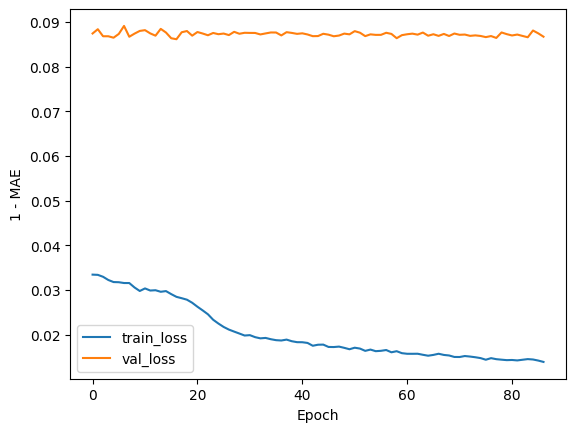

AttributeError: module 'matplotlib' has no attribute 'pyplot'

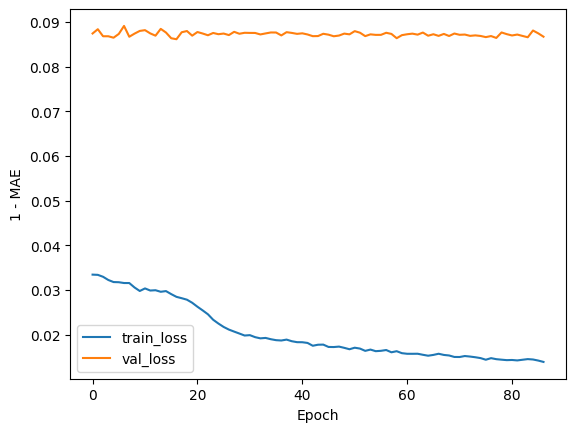

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [ ]:
from matplotlib import pyplot as plt

plt.clf()
plt.plot(temp_1, label='train_loss')
plt.plot(temp_2, label='val_loss')
# plt.title('')
plt.xlabel('Epoch')
plt.ylabel('1 - MAE')
plt.legend()
plt.show()

In [ ]:
from matplotlib import pyplot as plt

plt.clf()
plt.plot(temp_2, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('1 - MAE')
plt.legend()
plt.show()